This code calibrates of the HyMoLAP model and provides the multi-day ahead streamflow simulation in the Bonou sub-catchment.

In [ ]:
# Librairies
import pandas as pd
from matplotlib import pylab as plt
from datetime import datetime
import numpy as np
from math import sqrt
from numpy import concatenate

import math

from scipy.stats import norm

import joblib
import matplotlib.dates as mdates
from google.colab import files

import json
import plotly.graph_objects as go

In [ ]:
import random
import os
import tensorflow as tf

# Set random seeds for reproducibility
np.random.seed(35)
tf.random.set_seed(35)
random.seed(35)
os.environ['PYTHONHASHSEED'] = '35'

In [ ]:
#NSE, RMSE, KGE
def nash_sutcliffe_efficiency(observed, simulated):
    obs_mean = np.mean(observed)
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - obs_mean) ** 2)

    nse = 1 - (numerator / denominator)
    return nse

def calculate_rmse(observed, predicted):

    rmse = np.sqrt(np.mean((observed - predicted)**2))
    return rmse

def kge(obs, sim):
    """ Kling-Gupta Efficiency (KGE)"""
    obs, sim = np.array(obs), np.array(sim)

    r = np.corrcoef(obs, sim)[0, 1]
    beta = np.mean(sim) / np.mean(obs)
    gamma = (np.std(sim) / np.mean(sim)) / (np.std(obs) / np.mean(obs))

    return 1 - np.sqrt((r - 1)**2 + (beta - 1)**2 + (gamma - 1)**2)


 HyMoLAP Calibration

In [ ]:
# Import data
from google.colab import drive
drive.mount('/content/drive')

daily = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Bonou/calage_biao.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
daily.head()

,debit,pluie,etp
0,23.120001,0.6252,3.142820
1,22.760000,0.0000,2.982918
2,22.180000,0.0000,3.682083
3,21.590000,0.0000,3.758521
4,20.990000,0.0000,3.551428


Time series plot

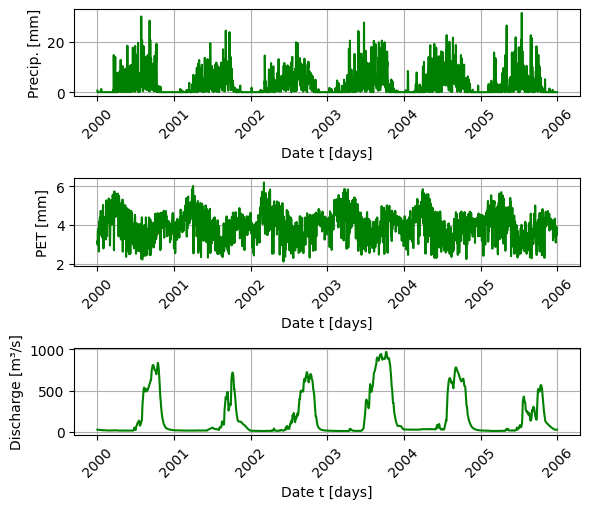

In [ ]:
# Adjusted figure size
plt.figure(figsize=(6, 5.2))

# Analysis period: 1/7/2002 to 31/12/2007
start_date = '2000-01-01'
end_date = '2005-12-31'

# Example of dummy data (replace with actual data)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a dummy DataFrame (replace this with actual data)
dailyy = pd.DataFrame({
    'pluie': daily["pluie"].values,  # Example data for 'pluie'
    'etp': daily["etp"].values,      # Example data for 'etp'
    'debit': daily["debit"].values   # Example data for 'debit'
}, index=date_range)

# Define the period for the X-axis
start_year = 2000
end_year = 2006
years = list(range(start_year, end_year + 1))
ticks = pd.to_datetime([f'{year}-01-01' for year in years])

# Label names for the Y-axis
y_labels = {
    "debit": "Discharge [m³/s]",
    "pluie": "Precip. [mm]",
    "etp": "PET [mm]"
}

# Reorder variables in the desired order: "pluie", "etp", "debit"
ordered_vars = ["pluie", "etp", "debit"]

for i, var in enumerate(ordered_vars):
    plt.subplot(len(ordered_vars), 1, i + 1)

    # Plot data for each variable
    color = 'green' if var == "debit" else 'green'  # Green for 'debit', green for others
    plt.plot(dailyy.index, dailyy[var], color=color)

    # Set axis labels and titles
    plt.xlabel('Date t [days]')
    plt.ylabel(y_labels.get(var, var))

    # Add grid and adjust ticks
    plt.grid(True)

    # Define X-axis ticks
    plt.xticks(ticks=ticks, labels=[tick.year for tick in ticks], rotation=45)

# Use tight_layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


CALIBRATION

This is the calibration section. We perform the model calibration based on the observed discharge, precipitation and PET data. The calibration scenario is done considering one-day-ahead streamflow forecast scenario.

In [ ]:
#Calibration data
discharge = daily.iloc[:1461, 0].to_numpy()
prec = daily.iloc[:1461, 1].to_numpy()
pet = daily.iloc[:1461, 2].to_numpy()

In [ ]:
#X(t)
def state_basin(MU, LANDA, q):
    n = len(q)
    X = np.zeros(n)
    X[0] = q[0]
    for i in range(1, n):
        if q[i] == 0:
            X[i] = X[i - 1] - (MU / LANDA) * X[i - 1]
        else:
            X[i] = X[i - 1] + (MU / LANDA) * q[i]
    return X

In [ ]:
#Compute the Effective precipitation
prec_eff = prec - pet
prec_eff[prec_eff < 0] = 0

# initialization
nashe = 0
S = np.zeros(len(discharge))
S[0] = discharge[0]
Qsim = np.zeros(len(discharge))

for pp in range(10000):
    mu = (0.85 - 0.65) * np.random.rand() + 0.65
    lambda_ = (10 - 7) * np.random.rand() + 7

    X = state_basin(mu, lambda_, prec_eff)

    for k in range(0, len(discharge)-1):

        S[k+1] = discharge[k] - (mu/lambda_) * discharge[k]**(2*mu-1) + (1/lambda_) * X[k] * prec_eff[k]


    # Nash-Sutcliffe efficiency calculation
    nas = nash_sutcliffe_efficiency(discharge, S)
    if nashe < nas:
      nashe = nas
      MU = mu
      LAMBDA = lambda_
      Qsim = S.copy()

In [ ]:
#Estimates of the HyMoLAP
print(MU)
print(LAMBDA)

0.8001196845564451
8.242717863862458


In [ ]:
nse_value = nash_sutcliffe_efficiency(discharge[1:], Qsim[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge[1:], Qsim[1:]))

print('kge=', kge(discharge[1:], Qsim[1:]))

Nash-Sutcliffe Efficiency (NSE): 0.9974996265214557
rmse= 13.4856966902237
kge= 0.9981315294419818


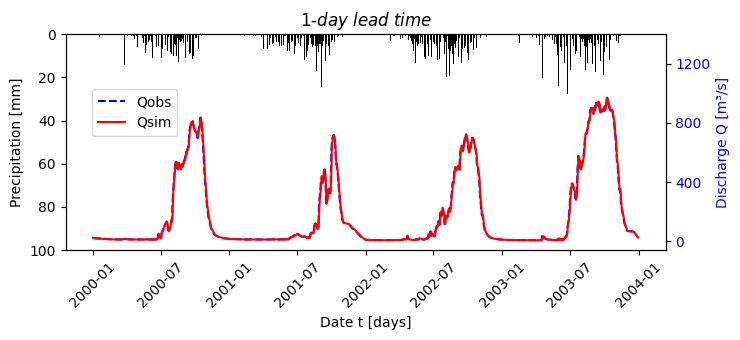

In [ ]:
# Define the date range
time1 = np.datetime64('2000-01-02')  # Start date
time2 = np.datetime64('2003-12-31')  # End date
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create the figure and axes with an adjusted size
fig, ax1 = plt.subplots(figsize=(7.5, 3.5))

# Plot the precipitation histogram on ax1
ax1.bar(time, prec[1:], color='black')

# Format the x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Configure the y-axis for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert the y-axis to display precipitation in reverse order
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis for discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge[1:], 'b--', label='Qobs')

# Plot the mean of the trajectories
ax2.plot(time, Qsim[1:], 'r', label='Qsim')

# Configure the y-axis for discharge
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-60, 1400)
ax2.set_yticks(np.arange(0, 1400, 400))

# Add a title to the plot with LaTeX mathematical symbols
plt.title(r'$1$-$day$ $lead$ $time$')

# Add a legend
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.75))

# Adjust the layout to avoid overlapping elements
plt.tight_layout()

# Display the plot
plt.show()


Multi-step prediction

VALIDATION

In [ ]:
# Validation data
discharge1 = daily.iloc[1461:, 0].to_numpy()
prec1 = daily.iloc[1461:, 1].to_numpy()
pet1 = daily.iloc[1461:, 2].to_numpy()

#Compute the Effective precipitation
prec_eff1 = prec1 - pet1
prec_eff1[prec_eff1 < 0] = 0

#X(t)
X = state_basin(MU, LAMBDA, prec_eff1)

1-day ahead

In [ ]:
#Simulation
def compute_Q(Q_t, psi_t, mu, lambda_):
    Q_next = Q_t +  (- (mu / lambda_) * Q_t**(2 * mu - 1) + (1 / lambda_) * psi_t)

    return Q_next

S71 = np.zeros(len(discharge1))
S71[0] = discharge1[0]

for k in range(0, len(discharge1)-1, 1):
    S71[k + 1] = compute_Q(discharge1[k], X[k] * prec_eff1[k], MU, LAMBDA)


In [ ]:
#Performance
nse_value = nash_sutcliffe_efficiency(discharge1[1:], S71[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge1[1:], S71[1:]))

print('kge=',kge(discharge1[1:], S71[1:]))


Nash-Sutcliffe Efficiency (NSE): 0.9966141715736393
rmse= 12.567122210618226
kge= 0.9975020866072433


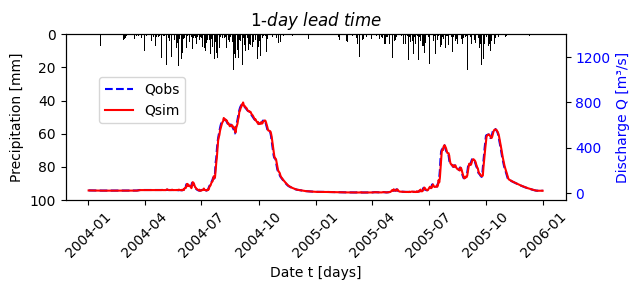

In [ ]:
# Create a date range from '01-01-2000' to '12-31-2005'
time1 = np.datetime64('2004-01-02')  # Start date
time2 = np.datetime64('2005-12-31')  # End date
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(6.5, 3.))

# Plot a histogram for precipitation on ax1
ax1.bar(time, prec1[1:], color='black')

# Format the x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Y-axis settings for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert the y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge1[1:], 'b--', label='Qobs')

# Plot minimum, maximum, and mean values as a confidence region
#ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='99% CrI')

# Plot the mean of the trajectories
ax2.plot(time, S71[1:], 'r', label='Qsim')

# Y-axis settings for daily discharge
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-60, 1400)
ax2.set_yticks(np.arange(0, 1400, 400))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.75))

# Display the grid
#plt.grid(True)

# Add a title to the plot with LaTeX mathematical symbols
plt.title(r'$1$-$day$ $lead$ $time$')

# Use tight_layout to avoid overlaps
plt.tight_layout()

# Display the plot
plt.show()


3-day ahead

In [ ]:
#Simulation
def compute_Q(Q_t, psi_t, mu, lambda_):
    Q_values = []
    for i in range(1, 4):
      if i==1:
        Q_next = Q_t +  (- (mu / lambda_) * Q_t**(2 * mu - 1) + (1 / lambda_) * psi_t)
        Q_values.append(Q_next)
        Q_prec = Q_t
        Q_t = Q_next
      else:
        Q_next = 2*Q_t-Q_prec
        Q_values.append(Q_next)
        Q_prec = Q_t
        Q_t = Q_next

    return tuple(Q_values)

S71 = np.zeros(len(discharge1))
S71[0] = discharge1[0]

for k in range(0, len(discharge1)-2, 3):  #loup
    (S71[k+1], S71[k+2], S71[k+3]) = \
        compute_Q(discharge1[k], X[k]*prec_eff1[k], MU, LAMBDA)


In [ ]:
#We check here the last value reached by the loup
S71[-2], S71[-1]

(21.030641883385012, 0.0)

In [ ]:
#We compute  streamflow for last days that were not considered in the loup
psi = X[-2]*prec_eff[-2]
S71[-1] = discharge1[-2] +  (- (MU / LAMBDA) * discharge1[-2]**(2 * MU - 1) + (1 / LAMBDA) * psi)

In [ ]:
#Performance
nse_value = nash_sutcliffe_efficiency(discharge1[1:], S71[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge1[1:], S71[1:]))

print('kge=',kge(discharge1[1:], S71[1:]))


Nash-Sutcliffe Efficiency (NSE): 0.9858373956692847
rmse= 25.702473858281124
kge= 0.9911441481312079


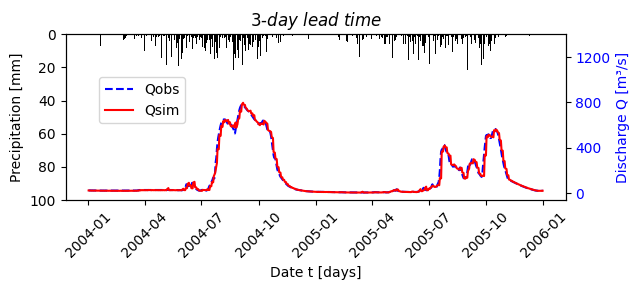

In [ ]:
# Create a date range from '01-01-2000' to '12-31-2005'
time1 = np.datetime64('2004-01-02')  # Start date
time2 = np.datetime64('2005-12-31')  # End date
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(6.5, 3.))

# Plot a histogram for precipitation on ax1
ax1.bar(time, prec1[1:], color='black')

# Format the x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Y-axis settings for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert the y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge1[1:], 'b--', label='Qobs')

# Plot minimum, maximum, and mean values as a confidence region
#ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='99% CrI')

# Plot the mean of the trajectories
ax2.plot(time, S71[1:], 'r', label='Qsim')

# Y-axis settings for daily discharge
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-60, 1400)
ax2.set_yticks(np.arange(0, 1400, 400))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.75))

# Display the grid
#plt.grid(True)

# Add a title to the plot with LaTeX mathematical symbols
plt.title(r'$3$-$day$ $lead$ $time$')

# Use tight_layout to avoid overlaps
plt.tight_layout()

# Display the plot
plt.show()


5-day ahead

In [ ]:
#Simulation
def compute_Q(Q_t, psi_t, mu, lambda_):
    Q_values = []
    for i in range(1, 6):
      if i==1:
        Q_next = Q_t +  (- (mu / lambda_) * Q_t**(2 * mu - 1) + (1 / lambda_) * psi_t)
        Q_values.append(Q_next)
        Q_prec = Q_t
        Q_t = Q_next
      else:
        Q_next = 2*Q_t-Q_prec
        Q_values.append(Q_next)
        Q_prec = Q_t
        Q_t = Q_next

    return tuple(Q_values)

S71 = np.zeros(len(discharge1))
S71[0] = discharge1[0]

for k in range(0, len(discharge1)-1, 5):
    (S71[k+1], S71[k+2], S71[k+3], S71[k+4], S71[k+5]) = \
        compute_Q(discharge1[k], X[k]*prec_eff1[k], MU, LAMBDA)


In [ ]:
S71[-2], S71[-1]

(20.394188999827477, 19.757736116269943)

In [ ]:
nse_value = nash_sutcliffe_efficiency(discharge1[1:], S71[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge1[1:], S71[1:]))

print('kge=',kge(discharge1[1:], S71[1:]))

Nash-Sutcliffe Efficiency (NSE): 0.9745243601009423
rmse= 34.471955126959614
kge= 0.9846655020115423


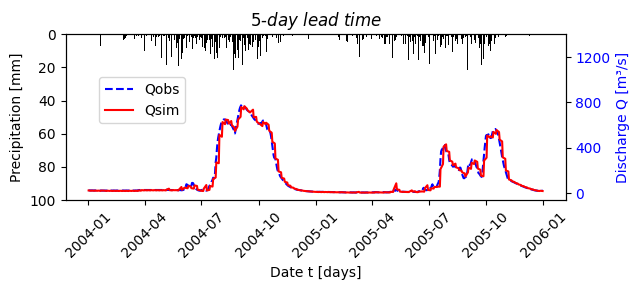

In [ ]:
# Create a date range from '01-01-2000' to '12-31-2005'
time1 = np.datetime64('2004-01-02')  # Start date
time2 = np.datetime64('2005-12-31')  # End date
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(6.5, 3.))

# Plot a histogram for precipitation on ax1
ax1.bar(time, prec1[1:], color='black')

# Format the x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Y-axis settings for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert the y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge1[1:], 'b--', label='Qobs')

# Plot minimum, maximum, and mean values as a confidence region
#ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='99% CrI')

# Plot the mean of the trajectories
ax2.plot(time, S71[1:], 'r', label='Qsim')

# Y-axis settings for daily discharge
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-60, 1400)
ax2.set_yticks(np.arange(0, 1400, 400))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.75))

# Display the grid
#plt.grid(True)

# Add a title to the plot with LaTeX mathematical symbols
plt.title(r'$5$-$day$ $lead$ $time$')

# Use tight_layout to avoid overlaps
plt.tight_layout()

# Display the plot
plt.show()


7-day ahead

In [ ]:
#Simulation
def compute_Q(Q_t, psi_t, mu, lambda_):
    Q_values = []
    for i in range(1, 8):
      if i==1:
        Q_next = Q_t +  (- (mu / lambda_) * Q_t**(2 * mu - 1) + (1 / lambda_) * psi_t)
        Q_values.append(Q_next)
        Q_prec = Q_t
        Q_t = Q_next
      else:
        Q_next = 2*Q_t-Q_prec
        Q_values.append(Q_next)
        Q_prec = Q_t
        Q_t = Q_next

    return tuple(Q_values)

S71 = np.zeros(len(discharge1))
S71[0] = discharge1[0]

for k in range(0, len(discharge1)-3, 7):
    (S71[k+1], S71[k+2], S71[k+3], S71[k+4], S71[k+5], S71[k+6], S71[k+7]) = \
        compute_Q(discharge1[k], X[k]*prec_eff1[k], MU, LAMBDA)


In [ ]:
S71[-3], S71[-2]

(18.484830349154873, 0.0)

In [ ]:
psi = X[-3]*prec_eff[-3]
S71[-2] = discharge1[-3] +  (- (MU / LAMBDA) * discharge1[-3]**(2 * MU - 1) + (1 / LAMBDA) * psi)

S71[-1] = 2*S71[-2] - S71[-3]

In [ ]:
nse_value = nash_sutcliffe_efficiency(discharge1[1:], S71[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge1[1:], S71[1:]))

print('kge=',kge(discharge1[1:], S71[1:]))

Nash-Sutcliffe Efficiency (NSE): 0.9548429667739058
rmse= 45.895073081653564
kge= 0.9766946404874096


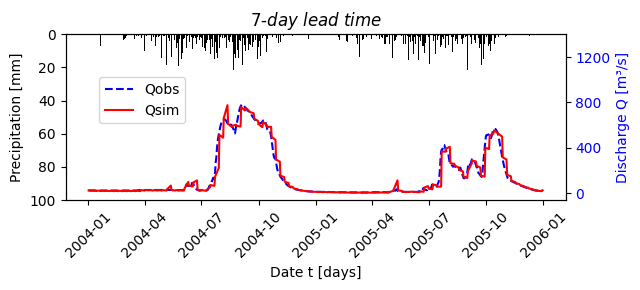

In [ ]:
# Create a date range from '01-01-2000' to '12-31-2005'
time1 = np.datetime64('2004-01-02')  # Start date
time2 = np.datetime64('2005-12-31')  # End date
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(6.5, 3.))

# Plot a histogram for precipitation on ax1
ax1.bar(time, prec1[1:], color='black')

# Format the x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Y-axis settings for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert the y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge1[1:], 'b--', label='Qobs')

# Plot minimum, maximum, and mean values as a confidence region
#ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='99% CrI')

# Plot the mean of the trajectories
ax2.plot(time, S71[1:], 'r', label='Qsim')

# Y-axis settings for daily discharge
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-60, 1400)
ax2.set_yticks(np.arange(0, 1400, 400))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.75))

# Display the grid
#plt.grid(True)

# Add a title to the plot with LaTeX mathematical symbols
plt.title(r'$7$-$day$ $lead$ $time$')

# Use tight_layout to avoid overlaps
plt.tight_layout()

# Display the plot
plt.show()


10-day ahead

In [ ]:
#Simulation
def compute_Q(Q_t, psi_t, mu, lambda_):
    Q_values = []
    for i in range(1, 11):
      if i==1:
        Q_next = Q_t +  (- (mu / lambda_) * Q_t**(2 * mu - 1) + (1 / lambda_) * psi_t)
        Q_values.append(Q_next)
        Q_prec = Q_t
        Q_t = Q_next
      else:
        Q_next = 2*Q_t-Q_prec
        Q_values.append(Q_next)
        Q_prec = Q_t
        Q_t = Q_next

    return tuple(Q_values)

S71 = np.zeros(len(discharge1))
S71[0] = discharge1[0]

for k in range(0, len(discharge1)-1, 10):
    (S71[k+1], S71[k+2], S71[k+3], S71[k+4], S71[k+5], S71[k+6], S71[k+7],
     S71[k+8], S71[k+9], S71[k+10]) = \
        compute_Q(discharge1[k], X[k]*prec_eff1[k], MU, LAMBDA)


In [ ]:
S71[-1]

16.575471698482268

In [ ]:
nse_value = nash_sutcliffe_efficiency(discharge1[1:], S71[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge1[1:], S71[1:]))

print('kge=',kge(discharge1[1:], S71[1:]))


Nash-Sutcliffe Efficiency (NSE): 0.9209378641031676
rmse= 60.72781234777631
kge= 0.958973857898287


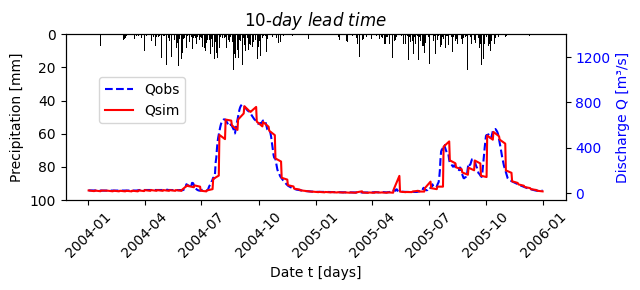

In [ ]:
# Create a date range from '01-01-2000' to '12-31-2005'
time1 = np.datetime64('2004-01-02')  # Start date
time2 = np.datetime64('2005-12-31')  # End date
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(6.5, 3.))

# Plot a histogram for precipitation on ax1
ax1.bar(time, prec1[1:], color='black')

# Format the x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Y-axis settings for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert the y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge1[1:], 'b--', label='Qobs')

# Plot minimum, maximum, and mean values as a confidence region
#ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='99% CrI')

# Plot the mean of the trajectories
ax2.plot(time, S71[1:], 'r', label='Qsim')

# Y-axis settings for daily discharge
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-60, 1400)
ax2.set_yticks(np.arange(0, 1400, 400))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.75))

# Display the grid
#plt.grid(True)

# Add a title to the plot with LaTeX mathematical symbols
plt.title(r'$10$-$day$ $lead$ $time$')

# Use tight_layout to avoid overlaps
plt.tight_layout()

# Display the plot
plt.show()
